some error: row info = ['x-coords', 'y-coords', 'contactAngle']
Calculated Cap.Nr's from CA_adv, _mid & _rec: 4.55E-08, 4.81E-08, 1.22E-07


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Downloads\\CA vs azimuthal Ca=4e-08, x=1e-05, l=3e-09.png'

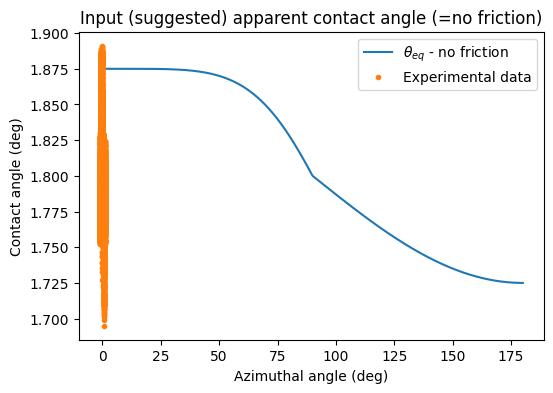

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import csv
import json
import scipy.optimize

#define img nr
imgNr = 32
#define folder path
folder_path = "G:\\2024_05_07_PLMA_Basler15uc_Zeiss5x_dodecane_Xp1_31_S2_WEDGE_2coverslip_spacer_V3\\Analysis CA Spatial"
#import CA datafile paths
file_paths = [os.path.join(folder_path, f"ContactAngleData {imgNr}.csv")]

#import middle coord
with open(os.path.join(folder_path, f"Analyzed Data\\{imgNr}_analysed_data.json"), 'r') as file:
    json_data = json.load(file)
middleCoord = json_data['middleCoords-surfaceArea']

#import data from csv datafiles
xcoord = []
ycoord = []
CA = []
for file_path in file_paths:
    with open(file_path, newline='') as csvfile:
        data = csv.reader(csvfile, delimiter = ',')
        for row in data:
            try:
                xcoord.append(int(row[0]))
                ycoord.append(int(row[1]))
                CA.append(float(row[2]))
            except:
                print(f"some error: row info = {row}")

#Plot spatial experimental CA profile vs X,Y-Coords
#TODO uncomment
# fig5, ax5 = plt.subplots(figsize=(9,6))
# im5 = ax5.scatter(xcoord, ycoord, c=CA, cmap='jet', vmin=min(CA), vmax=max(CA))
# ax5.set(xlabel = "X-coord", ylabel = "Y-Coord");
# ax5.set_title(f"Experimental data\nSpatial Apparent Contact Angles Colormap", fontsize = 20)

def coordsToPhi(xArrFinal, yArrFinal, medianmiddleX, medianmiddleY):
    """
    :return phi: range [-pi : pi]
    :return rArray: distance from the middle to the coordinate. UNIT= same as input units (so probably pixel, or e.g. mm)

    phi = 0 at right side -> 0.5pi at top -> 1pi at left -> -1pi at left -> -0.5pi at bottom
    example how phi evolves: https://stackoverflow.com/questions/17574424/how-to-use-atan2-in-combination-with-other-radian-angle-systems
    """
    dx = np.subtract(xArrFinal, medianmiddleX)
    dy = np.subtract(yArrFinal, medianmiddleY)
    phi = np.arctan2(dy, dx)  # angle of contour coordinate w/ respect to 12o'clock (radians)
    rArray = np.sqrt(np.square(dx) + np.square(dy))
    return phi, rArray

def convertPhiToazimuthal(phi):
    """
    :param phi: np.array of atan2 radians   [-pi, pi]
    :return np.sin(phi2): np.array of azimuthal angle [-1, 1] rotating clockwise, starting at with 0 at top
    :return phi2: np.array of normal radians [0, 2pi] rotating clockwise starting at top.
    """
    phi1 = 0.5 * np.pi - phi
    phi2 = np.mod(phi1, (2.0 * np.pi))  # converting atan2 to normal radians: https://stackoverflow.com/questions/17574424/how-to-use-atan2-in-combination-with-other-radian-angle-system
    return np.sin(phi2), phi2

def fitSpatialCA(xcoord, ycoord, CA, middleCoord):
    #Convert x,y-coords to radial angle (phi)
    phi, rArray = coordsToPhi(xcoord, ycoord, middleCoord[0], 4608 - middleCoord[1])
    azimuthalX, phi_normalRadians = convertPhiToazimuthal(phi)
    
    #TODO uncomment
    # fig6, ax6 = plt.subplots()
    # ax6.plot(azimuthalX, CA, marker='.')
    # plt.show()
    

    #Ca is variable over phi, because of Ca = mu * v(phi!) / gamma : in which mu=viscosity, v=velocity (phi dependent + or -), gamma=surface tension
    #dodecane mu=1.34mPas       gamma = 25.55mN/m       #v is to be in m/s
    mu = 1.34 / 1000            #Pa*s                   
    gamma = 25.55/1000          #N/m
    #TODO for now let's say v = 50um/min
    v = 50*1E-6 / 60            #m/s
    CapNr = lambda v, mu, gamma: mu * v / gamma
        
    anglerange = np.linspace(0,1,1000)          #0-1pi 
    angle = np.linspace(0, np.pi, 1000)        #0-pi

    k = 3                                       #power order for 'steepness' of sin curve
    
#    f_theta_eq = lambda anglerange, k: (((0.5+np.sin(anglerange*np.pi-np.pi/2)/2)**((2*(1-anglerange))**k))*2 + 1) * np.pi / 180           #base function - [1-3], so around 2+-1
    CA_eq_adv = 1.875; CA_eq_rec = 1.725        # CA [deg] values observed from spatial CA profile: local max & minima on location where friction should not play big of a role - basically the max & min CA values
    Ca_eq_mid = (CA_eq_adv + CA_eq_rec)/2       # 'middle' CA value around which we build the sinus-like profile
    Ca_eq_diff = CA_eq_adv-Ca_eq_mid            # difference between middle CA value & the 'eq' ones - for in the sinus-like function
    f_theta_eq = lambda anglerange, k: (((0.5+np.sin(anglerange*np.pi-np.pi/2)/2)**((2*(1-anglerange))**k))*2 -1) * np.pi / 180             #base function - [-1,1], so around 0+-1
    theta_eq_cover = np.flip(f_theta_eq(anglerange[:len(anglerange)//2], 0))     #under cover = less steep
    theta_eq_open = np.flip(f_theta_eq(anglerange[len(anglerange)//2:], 3))     #open air = steep
    theta_eq = np.concatenate([theta_eq_open, theta_eq_cover])  * 180 / np.pi
    #perform operation to shift CA values to desired CA_eq range
    theta_eq = theta_eq*Ca_eq_diff + Ca_eq_mid  
    
    #Calculate theta_apparent:
    prefactor = 9   #OG = 9
    R = 10E-6       #slip length, 10 micron?                     -macroscopic
    l = 3E-9        #capillary length, ongeveer              -microscopic
    Ca = 4E-8 * np.sin(angle-np.pi/2)  #OG standard Ca curve: normal sinus between + and - the value.  OG = -1.55E-7 *
    print(f"Calculated Cap.Nr's from CA_adv, _mid & _rec: {CapNr(52*1E-6 / 60, mu, gamma):.2E}, {CapNr(55*1E-6 / 60, mu, gamma):.2E}, {CapNr(140*1E-6 / 60, mu, gamma):.2E}")
    theta_app = ((theta_eq / 180 * np.pi)**3 + prefactor*Ca*np.log(R/l))**(1/3)  * 180 / np.pi               #[deg]
    
    # Fit theta_app to real data: fitting Cappilary number
    
    #TODO fix deze & check in plot aziX niet goed
    f_theta_app = lambda theta_eq, Ca, R, l: (9 * Ca * np.log(R/l) + theta_eq**3)**(1/3)

    
    
    
    #plot eq & apparent contact angle vs azimuthal angle
    fig1, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(angle*180/np.pi, theta_eq, label=r'$\theta_{eq}$ - no friction')
    #ax1.plot(angle*180/np.pi, theta_app, '.', label = r'$\theta_{app}$ - with friction')
    ax1.plot(azimuthalX, CA, '.', label=f'Experimental data')
    
    ax1.set(xlabel='Azimuthal angle (deg)', ylabel='Contact angle (deg)', title='Input (suggested) apparent contact angle (=no friction)') #title='Example influence hydrolic resistance on apparent contact angle'
    ax1.legend(loc='best')
    fig1.savefig(f"C:\\Downloads\\CA vs azimuthal Ca={max(Ca)}, x={R}, l={l}.png", dpi=600)
    plt.show()
    
    # fig7, ax7 = plt.subplots()
    # ax7.plot(anglerange, theta_eq, marker='.')
    # ax7.set(title = 'new CA Eq profile', xlabel = 'azimuthal angle [deg]', ylabel = 'CA angle [deg]')
    # plt.show()
    
    #plot eq (NO FRICTION) contact angle vs 'spatial X,Y-coordinates'
    fig3, ax3 = plt.subplots(figsize=(9,6))
    xArrFinal = np.cos(anglerange * np.pi)
    yArrFinal = np.sin(anglerange* np.pi)
    im3 = ax3.scatter([xArrFinal, np.flip(xArrFinal)], [yArrFinal, -np.flip(yArrFinal)], c=[np.flip(theta_eq), theta_eq], cmap='jet', vmin=min(theta_eq), vmax=max(theta_eq))
    ax3.set_xlabel("X-coord"); ax3.set_ylabel("Y-Coord");
    ax3.set_title(f"Model: No Hydrolic Resistance \nSpatial Equilibrium Contact Angles Colormap", fontsize = 20)
    fig3.colorbar(im3)
    #fig3.savefig("C:\\Downloads\\NOhydrolic.png", dpi=600)
    
    #plot apparent (W/ FRICTION) contact angle vs 'spatial X,Y-coordinates'
    fig4, ax4 = plt.subplots(figsize=(9,6))
    im4 = ax4.scatter([xArrFinal, np.flip(xArrFinal)], [yArrFinal, -np.flip(yArrFinal)], c=[np.flip(theta_app), theta_app], cmap='jet', vmin=min(theta_app), vmax=max(theta_app))
    ax4.set_xlabel("X-coord"); ax4.set_ylabel("Y-Coord");
    ax4.set_title(f"Model: Effect of viscous friction\nSpatial Predicted Apparent Contact Angles Colormap", fontsize = 20)
    fig4.colorbar(im4)
    #fig4.savefig(f"C:\\Downloads\\YEShydrolic Ca={max(Ca)}, x={x}, l={l}.png", dpi=600)
    
    return 

fitSpatialCA(xcoord, ycoord, CA, middleCoord)

angle = np.linspace(0, np.pi, 1000)
#theta_eq = (np.sin(angle-np.pi/2) + 2) * np.pi / 180

# Ca = -1.55E-7 * np.sin(angle-np.pi/2)  #OG standard Ca curve: normal sinus between + and - the value
# fig1, ax1 = plt.subplots(figsize=(6,4))
# ax1.plot(angle*180/np.pi, Ca)
# ax1.set(xlabel = 'Contact angle', ylabel = 'Capillary number')


In [ ]:
x = 10E-6   #slip length, 10 micron?                     -macroscopic
l = 3E-9       #capillary length, ongeveer              -microscopic

# for x in [10E-6]:
#     
#     anglerange = np.linspace(0,1,1000)
#     k = 3
#     #Ca = -1E-6 * ((((0.5+np.sin(anglerange*np.pi-np.pi/2)/2)**((2*(1-anglerange))**k)))*2 - 1)
#     theta_eq = (((0.5+np.sin(anglerange*np.pi-np.pi/2)/2)**((2*(1-anglerange))**k))*2 + 1) * np.pi / 180
#     prefactor = 9  #OG = 9
#     theta_app = (theta_eq**3 + prefactor*Ca*np.log(x/l))**(1/3)
#     print(f"{x/l}")
#     print(f"{prefactor*np.log(x/l)}")
#     
#     #xOverL = 0.01
#     #theta_app = (theta_eq**3 + 9*Ca*np.log(xOverL))**(1/3)
#     
#     #plot eq & apparent contact angle vs azimuthal angle
#     fig1, ax1 = plt.subplots(figsize=(6,4))
#     ax1.plot(angle*180/np.pi, theta_eq * 180 / np.pi, label=r'$\theta_{eq}$ - no friction')
#     ax1.plot(angle*180/np.pi, theta_app * 180 / np.pi, '.', label = r'$\theta_{app}$ - with friction')
#     ax1.set(xlabel='Azimuthal angle (deg)', ylabel='Contact angle (deg)', title='Example influence hydrolic resistance on apparent contact angle')
#     ax1.legend(loc='best')
#     fig1.savefig(f"C:\\Downloads\\CA vs azimuthal Ca={max(Ca)}, x={x}, l={l}.png", dpi=600)
# 
# 
#     #convert contact angles from rad->deg
#     theta_eq = theta_eq * 180 / np.pi
#     theta_app = theta_app * 180 / np.pi
#     
#     #plot eq (NO FRICTION) contact angle vs 'spatial X,Y-coordinates'
#     fig3, ax3 = plt.subplots(figsize=(9,6))
#     xArrFinal = np.cos(angle)
#     yArrFinal = np.sin(angle)
#     im3 = ax3.scatter([xArrFinal, np.flip(xArrFinal)], [yArrFinal, -np.flip(yArrFinal)], c=[theta_eq, np.flip(theta_eq)], cmap='jet', vmin=min(theta_eq), vmax=max(theta_eq))
#     ax3.set_xlabel("X-coord"); ax3.set_ylabel("Y-Coord");
#     ax3.set_title(f"Model: No Hydrolic Resistance \nSpatial Equilibrium Contact Angles Colormap", fontsize = 20)
#     fig3.colorbar(im3)
#     fig3.savefig("C:\\Downloads\\NOhydrolic.png", dpi=600)
# 
#     #plot apparent (W/ FRICTION) contact angle vs 'spatial X,Y-coordinates'
#     fig4, ax4 = plt.subplots(figsize=(9,6))
#     im4 = ax4.scatter([xArrFinal, np.flip(xArrFinal)], [yArrFinal, -np.flip(yArrFinal)], c=[theta_app, np.flip(theta_app)], cmap='jet', vmin=min(theta_app), vmax=max(theta_app))
#     ax4.set_xlabel("X-coord"); ax4.set_ylabel("Y-Coord");
#     ax4.set_title(f"Model: Effect of viscous friction\nSpatial Predicted Apparent Contact Angles Colormap", fontsize = 20)
#     fig4.colorbar(im4)
#     fig4.savefig(f"C:\\Downloads\\YEShydrolic Ca={max(Ca)}, x={x}, l={l}.png", dpi=600)

